In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [3]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [4]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

traffic-signs-preprocessed.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
%ls

data0.pickle  data7.pickle            mean_image_rgb.pickle
data1.pickle  data8.pickle            std_gray.pickle
data2.pickle  datasets_preparing.py   std_rgb.pickle
data3.pickle  kaggle.json             test.pickle
data4.pickle  label_names.csv         traffic-signs-preprocessed.zip
data5.pickle  labels.pickle           train.pickle
data6.pickle  mean_image_gray.pickle  valid.pickle


In [ ]:
!unzip /content/drive/MyDrive/kaggle/traffic-signs-preprocessed.zip

Archive:  /content/drive/MyDrive/kaggle/traffic-signs-preprocessed.zip
replace data0.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Import Libraries

In [6]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [7]:
# load traininig data

with open('/content/drive/MyDrive/kaggle/train.pickle', 'rb') as f:
  train_data = pickle.load(f)

print(type(train_data))

<class 'dict'>


In [8]:
train_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [9]:
print('Shape of train_data_feature :', train_data['features'].shape)
print('Shape of train_data_label :', train_data['labels'].shape)

Shape of train_data_feature : (34799, 32, 32, 3)
Shape of train_data_label : (34799,)


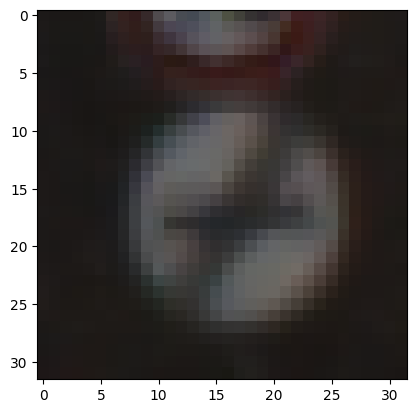

In [10]:
#show one example of the training data
plt.imshow(train_data['features'][0], interpolation='nearest')
plt.show()

In [11]:
#laod test data

with open('/content/drive/MyDrive/kaggle/test.pickle', 'rb') as f:
  test_data = pickle.load(f)

In [12]:
print('Shape of test_data_feature :', test_data['features'].shape)
print('Shape of test_data_label :', test_data['labels'].shape)

Shape of test_data_feature : (12630, 32, 32, 3)
Shape of test_data_label : (12630,)


In [13]:
#load validation data

with open('/content/drive/MyDrive/kaggle/valid.pickle', 'rb') as f:
  valid_data = pickle.load(f)

In [14]:
print('Shape of validation_data_feature :', valid_data['features'].shape)
print('Shape of validation_data_label :', valid_data['labels'].shape)

Shape of validation_data_feature : (4410, 32, 32, 3)
Shape of validation_data_label : (4410,)


In [15]:
# read labels calss of data
label = pd.read_csv('/content/drive/MyDrive/kaggle/label_names.csv')

In [16]:
label.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [17]:
#convert to list

labels = list(label['SignName'])
labels

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'Right-of-way at the next intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End of all speed and passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End of no passing 



Dataset and Dataloader 

In [18]:
transform = transforms.Compose([transforms.ToTensor()])

In [19]:
class Trafficsign(Dataset):
  def __init__(self, data, transform = None):
    self.features = data['features']
    self.labels = data['labels']
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    image = self.features[idx]
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)
    
    return image, label


In [20]:
train_dataset = Trafficsign(train_data, transform=transform)
valid_dataset = Trafficsign(valid_data, transform=transform)
test_dataset = Trafficsign(test_data, transform=transform)

In [21]:
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [22]:
from typing import List, Tuple

def plot_loss_curves(results, title):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize  = (12, 4))
  plt.suptitle(title, fontsize = 15)


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = 'train_loss' )
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


   # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


def calculate_performance(
    model:torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    device: torch.device,
    class_names: List[str], 
    title: str) -> Tuple[float, float, float]:
  model.eval()

  y_pred = []
  y_true = []
  test_acc = 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            output = (torch.max(torch.exp(test_pred_logits), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = y.data.cpu().numpy()
            y_true.extend(labels)

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  test_acc = test_acc / len(dataloader)
  cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
  f1 = f1_score(y_true, y_pred, average='macro')
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')

  df_cm = pd.DataFrame(cf_matrix, index=[i for i in class_names],
                         columns=[i for i in class_names])
  plt.figure(figsize=(32, 32))
  plt.title(title)
  sns.heatmap(df_cm, annot=True)
  plt.show()

  return test_acc, f1, precision, recall
  

Build neural network

In [23]:
import torch.nn as nn

class CNN(nn.Module):
  def __init__(self, input_shape : int, output_shape : int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = 32, 
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels = 32,
                  out_channels = 32,
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(p = 0.25)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = 32,
                  out_channels = 64,
                  kernel_size = 3,
                  padding = 1),
       nn.ReLU(), 
       nn.BatchNorm2d(64),
       nn.Conv2d(in_channels = 64,
                 out_channels = 64,
                 kernel_size = 3,
                 padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size = 2),
      nn.Dropout(p = 0.25) 
    )
    self.conv_block_3 = nn.Sequential(
      nn.Conv2d(in_channels = 64,
                out_channels = 128,
                kernel_size = 3,
                padding = 1),
      nn.ReLU(), 
      nn.BatchNorm2d(128),
      nn.Conv2d(in_channels = 128,
                out_channels = 128,
                kernel_size = 3,
                padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(kernel_size = 2),
      nn.Dropout(p = 0.25) 
    ) 
    self.conv_block_4 = nn.Sequential(
      nn.Conv2d(in_channels = 128,
                out_channels = 256,
                kernel_size = 3,
                padding = 1),
      nn.ReLU(), 
      nn.BatchNorm2d(256),
      nn.Conv2d(in_channels = 256,
                out_channels = 256,
                kernel_size = 3,
                padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(kernel_size = 2),
      nn.Dropout(p = 0.25) 
    ) 

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 256 * 2* 2, out_features = 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features =512, out_features = 1024),
        nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=output_shape)
     )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.conv_block_4(x)
    x = self.classifier(x)
    return x


In [24]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    This function defines a training step for a PyTorch mode
      
        Parameters:
                model: A PyTorch model that will be trained.
                dataloader: A PyTorch data loader that provides batches of training data.
                loss_fn: A PyTorch loss function that will be used to calculate the loss.
                optimizer: A PyTorch optimizer that will be used to update the model parameters.
                device: A PyTorch device that specifies where the computation will take place (e.g., "cpu" or "cuda").
        Returns:
               The function returns a tuple containing two values: the average training loss and the average training accuracy for a single epoch. 
    """

    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode(): #context manager is used to disable gradient computation during testing,which can improve performance and reduce memory usage.

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """
    This function defines the main training loop for a PyTorch model. 
      
        Parameters:
                model: A PyTorch model that will be trained.
                train_dataloader: A PyTorch data loader that provides batches of training data.
                test_dataloader: A PyTorch data loader that provides batches of test data.
                optimizer: A PyTorch optimizer that will be used to update the model parameters.
                loss_fn: A PyTorch loss function that will be used to calculate the loss.
                epochs: An integer specifying the number of training epochs.
                device: A PyTorch device that specifies where the computation will take place (e.g., "cpu" or "cuda").
        Returns:
               The function returns a dictionary containing four lists: the training loss, training accuracy, test loss, and test accuracy for each epoch. 
    """
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
torch.manual_seed(42)
custom_cnn = CNN(
    input_shape=3,
    output_shape=43
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=custom_cnn.parameters(), lr=0.01, momentum = 0.9)

In [ ]:
results_custom_cnn = train(
    custom_cnn,
    train_dataloader,
    valid_dataloader,
    optimizer, 
    loss_fn,
    epochs=10,
    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.0049 | train_acc: 0.2034 | test_loss: 4.6955 | test_acc: 0.3745
Epoch: 2 | train_loss: 1.6422 | train_acc: 0.5064 | test_loss: 0.9932 | test_acc: 0.6699
Epoch: 3 | train_loss: 0.8171 | train_acc: 0.7387 | test_loss: 0.6819 | test_acc: 0.7988
Epoch: 4 | train_loss: 0.4106 | train_acc: 0.8685 | test_loss: 0.4739 | test_acc: 0.8633
Epoch: 5 | train_loss: 0.2494 | train_acc: 0.9209 | test_loss: 0.3174 | test_acc: 0.9185
Epoch: 6 | train_loss: 0.1728 | train_acc: 0.9469 | test_loss: 0.3981 | test_acc: 0.9224
Epoch: 7 | train_loss: 0.1365 | train_acc: 0.9570 | test_loss: 0.2717 | test_acc: 0.9363
Epoch: 8 | train_loss: 0.0990 | train_acc: 0.9692 | test_loss: 0.2586 | test_acc: 0.9409
Epoch: 9 | train_loss: 0.1118 | train_acc: 0.9648 | test_loss: 0.6110 | test_acc: 0.9391
Epoch: 10 | train_loss: 0.0729 | train_acc: 0.9767 | test_loss: 0.2695 | test_acc: 0.9497


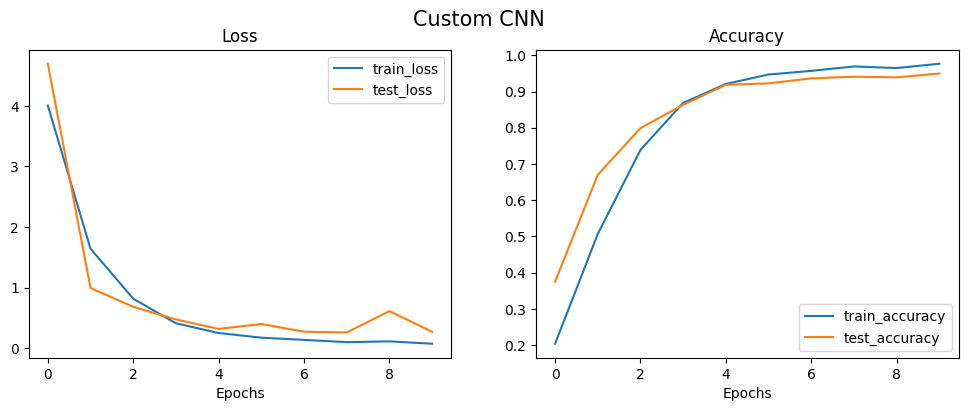

In [ ]:
plot_loss_curves(results_custom_cnn, title="Custom CNN")

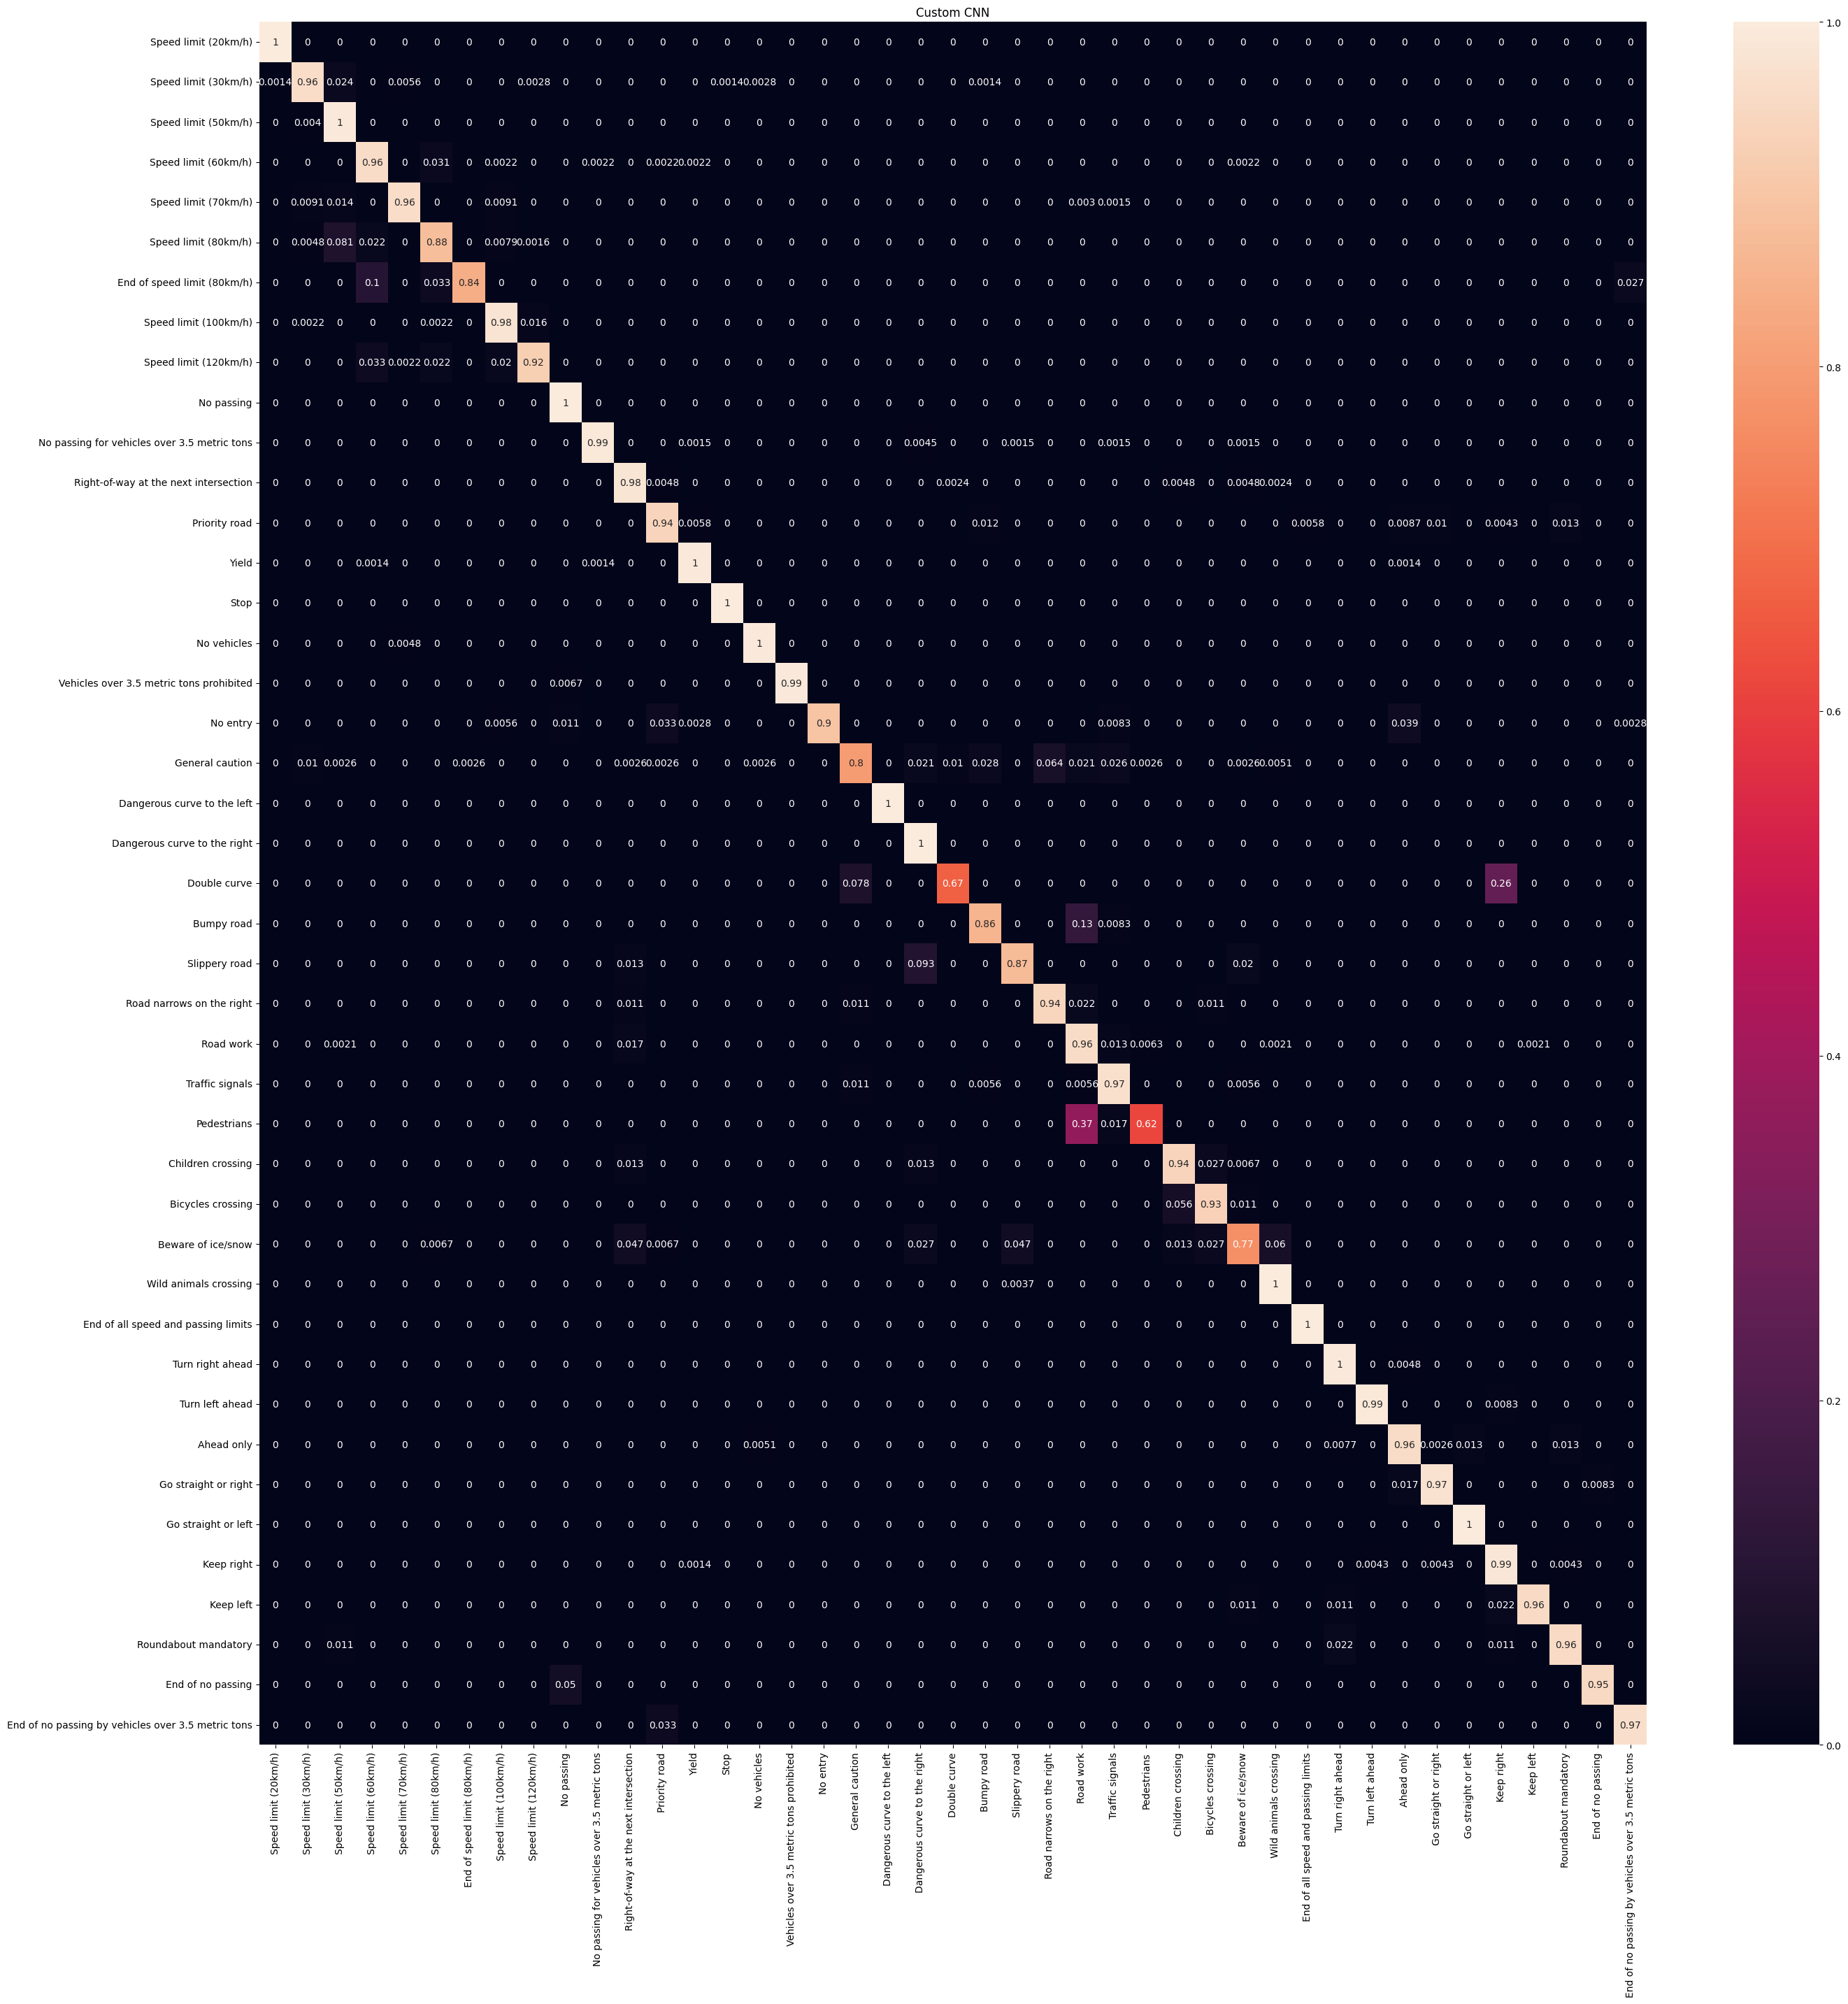

Accuracy = 0.9517908515535098, f1 score = 0.9365388753284917, precision = 0.940108750367026, recall = 0.9384589886202627


In [ ]:
acc, f1, precision, recall = calculate_performance(custom_cnn, 
                                                  test_dataloader, 
                                                  device, 
                                                  labels, 
                                                  "Custom CNN")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")


**Try to solve the problem using Transfer Learning by utilizing various pre-trained models.**

1.ResNet

In [ ]:
import torchvision

weights = torchvision.models.ResNet50_Weights.DEFAULT
model_resnet = torchvision.models.resnet50(weights=weights).to(device)
for param in model_resnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.8MB/s]


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(labels)

model_resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

manual_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = Trafficsign(train_data, transform=manual_transforms)
valid_dataset = Trafficsign(valid_data, transform=manual_transforms)
test_dataset = Trafficsign(test_data, transform=manual_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_resnet = train(model=model_resnet,
                       train_dataloader=train_dataloader,
                       test_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5113 | train_acc: 0.6117 | test_loss: 1.4208 | test_acc: 0.5878
Epoch: 2 | train_loss: 0.7811 | train_acc: 0.7914 | test_loss: 1.2984 | test_acc: 0.6234
Epoch: 3 | train_loss: 0.6100 | train_acc: 0.8335 | test_loss: 1.2217 | test_acc: 0.6461
Epoch: 4 | train_loss: 0.5222 | train_acc: 0.8516 | test_loss: 1.1808 | test_acc: 0.6615
Epoch: 5 | train_loss: 0.4601 | train_acc: 0.8663 | test_loss: 1.1950 | test_acc: 0.6591
Epoch: 6 | train_loss: 0.4295 | train_acc: 0.8720 | test_loss: 1.2142 | test_acc: 0.6535
Epoch: 7 | train_loss: 0.4028 | train_acc: 0.8778 | test_loss: 1.2227 | test_acc: 0.6606
Epoch: 8 | train_loss: 0.3787 | train_acc: 0.8844 | test_loss: 1.2015 | test_acc: 0.6678
Epoch: 9 | train_loss: 0.3682 | train_acc: 0.8846 | test_loss: 1.1727 | test_acc: 0.6734
Epoch: 10 | train_loss: 0.3527 | train_acc: 0.8895 | test_loss: 1.2258 | test_acc: 0.6685


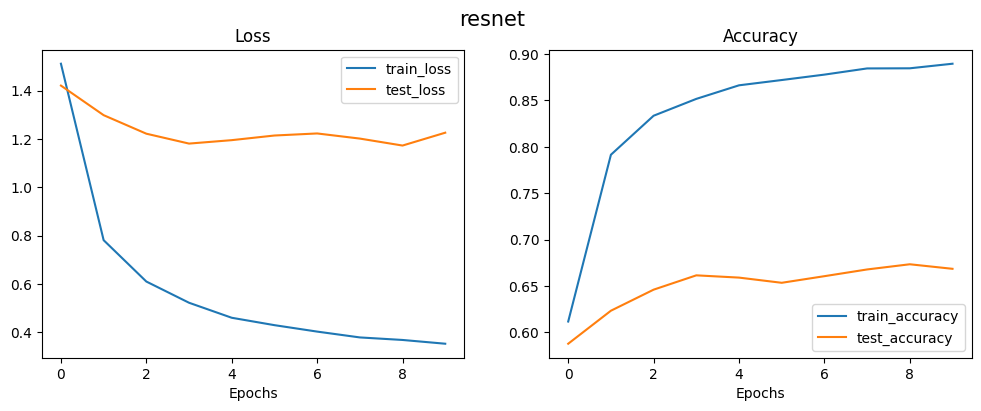

In [ ]:
plot_loss_curves(results_resnet, title="resnet")

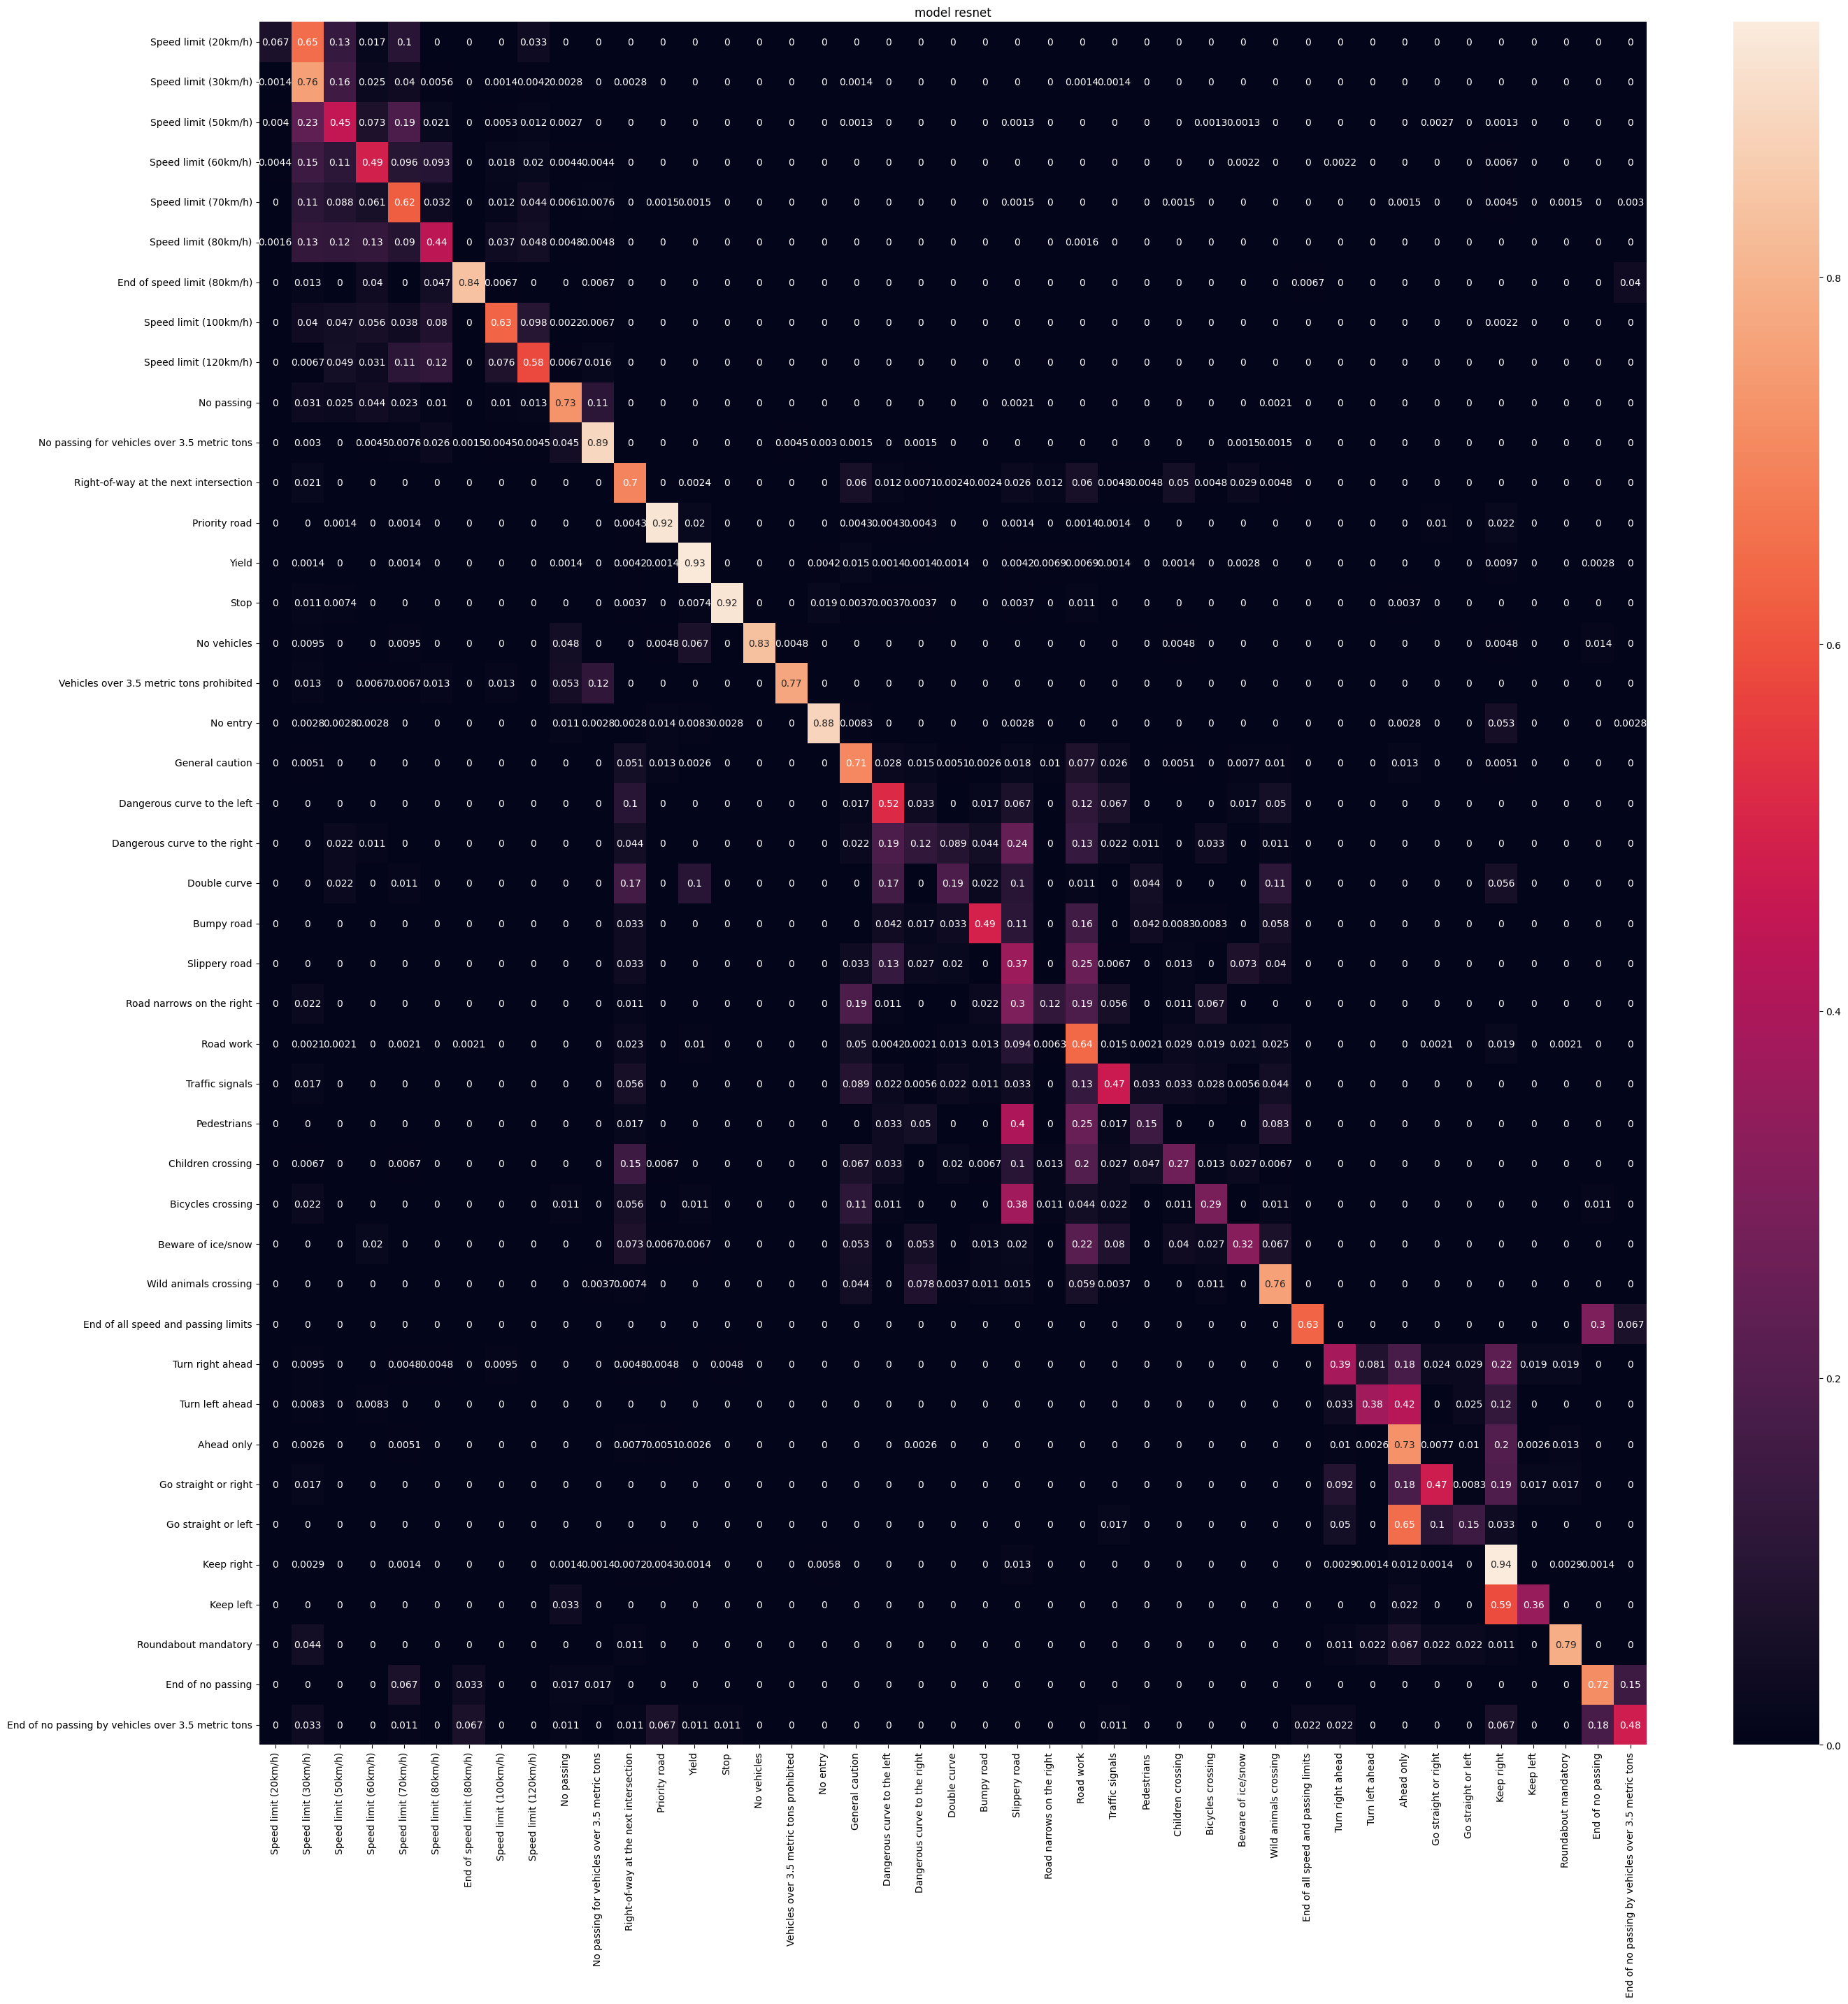

Accuracy = 0.6643483889528193, f1 score = 0.5740923792952015, precision = 0.6281777093983671, recall = 0.555664981705932


In [ ]:
acc, f1, precision, recall = calculate_performance(model_resnet, 
                                                  test_dataloader, 
                                                  device, 
                                                  labels, 
                                                  "model resnet")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")


2.VGG16_bn

In [ ]:
model_ft = torchvision.models.vgg16(pretrained=True)

for param in model_ft .parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:11<00:00, 46.5MB/s]


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(labels)
model_ft.classifier[-1] = torch.nn.Linear(4096, 
                    out_features=output_shape).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)

manual_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = Trafficsign(train_data, transform=manual_transforms)
valid_dataset = Trafficsign(valid_data, transform=manual_transforms)
test_dataset = Trafficsign(test_data, transform=manual_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_VGG = train(model=model_ft,
                       train_dataloader=train_dataloader,
                       test_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0473 | train_acc: 0.6714 | test_loss: 1.2262 | test_acc: 0.6177
Epoch: 2 | train_loss: 0.6875 | train_acc: 0.7698 | test_loss: 1.1735 | test_acc: 0.6577
Epoch: 3 | train_loss: 0.6208 | train_acc: 0.7915 | test_loss: 1.1137 | test_acc: 0.6797
Epoch: 4 | train_loss: 0.5908 | train_acc: 0.7991 | test_loss: 1.2114 | test_acc: 0.6703
Epoch: 5 | train_loss: 0.5750 | train_acc: 0.8063 | test_loss: 1.2123 | test_acc: 0.6729
Epoch: 6 | train_loss: 0.5572 | train_acc: 0.8124 | test_loss: 1.2544 | test_acc: 0.6790
Epoch: 7 | train_loss: 0.5511 | train_acc: 0.8167 | test_loss: 1.2769 | test_acc: 0.6832
Epoch: 8 | train_loss: 0.5372 | train_acc: 0.8196 | test_loss: 1.2851 | test_acc: 0.6828
Epoch: 9 | train_loss: 0.5342 | train_acc: 0.8216 | test_loss: 1.2832 | test_acc: 0.6908
Epoch: 10 | train_loss: 0.5414 | train_acc: 0.8253 | test_loss: 1.3108 | test_acc: 0.6727


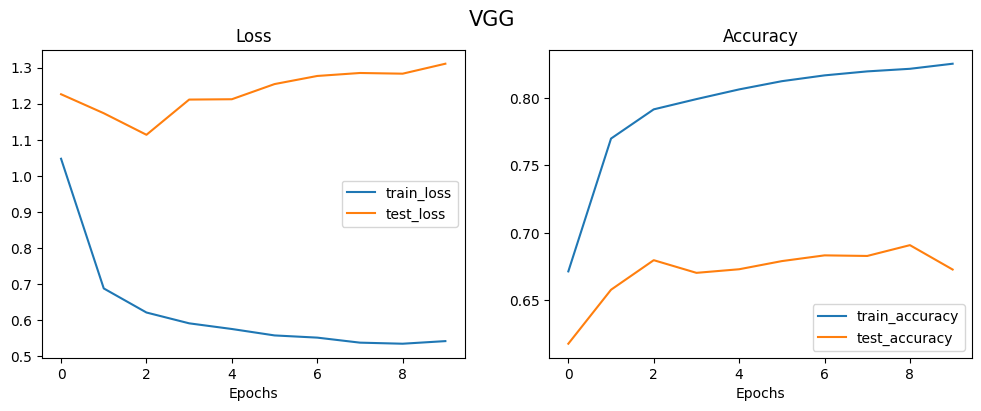

In [ ]:
plot_loss_curves(results_VGG, title="VGG")

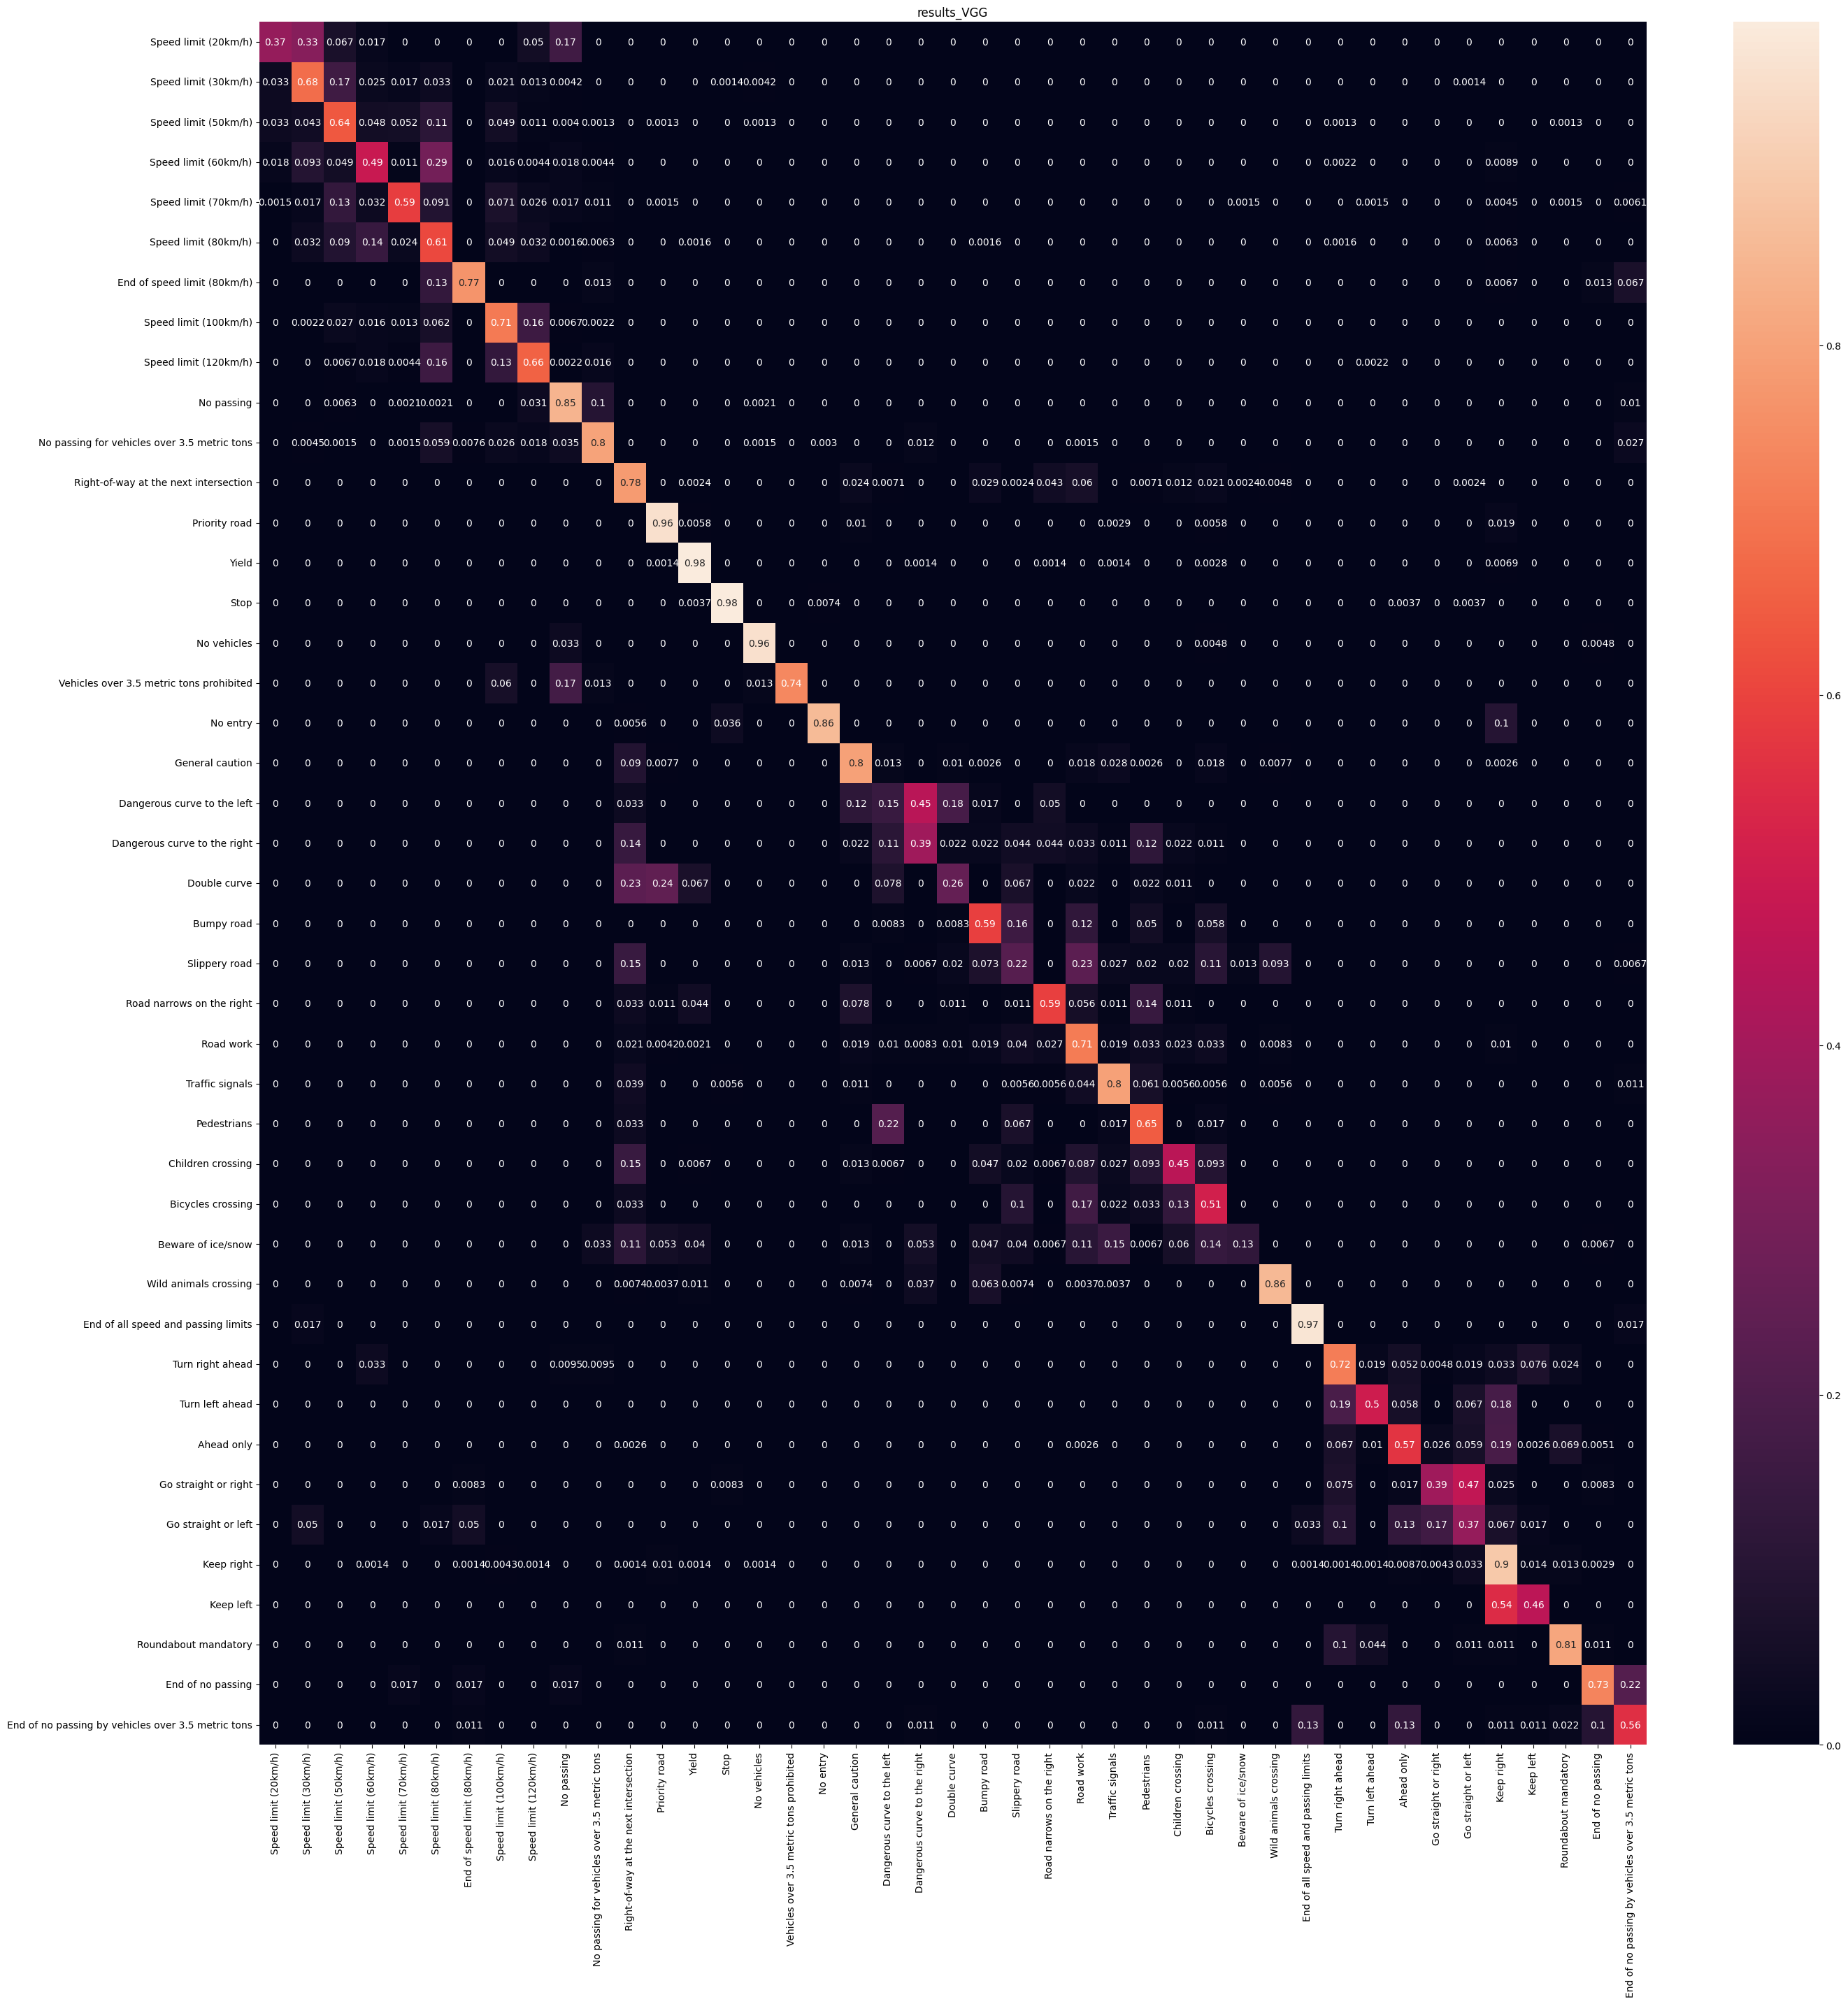

In [ ]:
acc, f1, precision, recall = calculate_performance(model_ft, 
                                                  test_dataloader, 
                                                  device, 
                                                  labels, 
                                                  "results_VGG")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")


In [ ]:
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")

Accuracy = 0.7160960874568469, f1 score = 0.6341160023539016, precision = 0.6595216075834275, recall = 0.6392573613706071


Try with grayscale

In [27]:
#convert training data with 3 channels into 1 channel
train_data['features'] = train_data['features'].astype(np.float32)
input_tensor_train = train_data['features']
gray_train_tensor = np.dot(input_tensor_train[...,:3], [0.299, 0.587, 0.114]).astype(np.float32)

print("Original shape:", input_tensor_train.shape)
print("Grayscale shape:", gray_train_tensor.shape)

Original shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32)


In [28]:
#convert test data with 3 channels into 1 channel
test_data['features'] = test_data['features'].astype(np.float32)
input_tensor_test = test_data['features']
gray_test_tensor = np.dot(input_tensor_test[...,:3], [0.299, 0.587, 0.114]).astype(np.float32)

print("Original shape:", input_tensor_test.shape)
print("Grayscale shape:", gray_test_tensor.shape)

Original shape: (12630, 32, 32, 3)
Grayscale shape: (12630, 32, 32)


In [29]:
#convert valid data with 3 channels into 1 channel
valid_data['features'] = valid_data['features'].astype(np.float32)
input_tensor_valid = valid_data['features']
gray_valid_tensor = np.dot(input_tensor_valid[...,:3], [0.299, 0.587, 0.114]).astype(np.float32)

print("Original shape:", input_tensor_valid.shape)
print("Grayscale shape:", gray_valid_tensor.shape)

Original shape: (4410, 32, 32, 3)
Grayscale shape: (4410, 32, 32)


In [30]:
gray_train = dict()
gray_valid = dict()
gray_test = dict()

gray_train['features'] = gray_train_tensor
gray_train['labels'] = train_data['labels']

gray_valid['features'] = gray_valid_tensor
gray_valid['labels'] = valid_data['labels']

gray_test['features'] = gray_test_tensor
gray_test['labels'] = test_data['labels']

In [31]:
transform = transforms.Compose([
    transforms.ToTensor()
])

gray_train_dataset = Trafficsign(gray_train, transform=transform)
gray_valid_dataset = Trafficsign(gray_valid, transform=transform)
gray_test_dataset = Trafficsign(gray_test, transform=transform)

train_dataloader = DataLoader(gray_train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dataloader = DataLoader(gray_valid_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(gray_test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_custom_gray = CNN(input_shape=1, output_shape=43)
model_custom_gray.to(device)

CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [33]:
optimizer = torch.optim.SGD(model_custom_gray.parameters(), lr=0.01, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

In [34]:
results_custom_gray = train(model_custom_gray,
                       train_dataloader,
                       valid_dataloader,
                       optimizer,
                       loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.4386 | train_acc: 0.1470 | test_loss: 3.2703 | test_acc: 0.2203
Epoch: 2 | train_loss: 2.0397 | train_acc: 0.4635 | test_loss: 0.7960 | test_acc: 0.7205
Epoch: 3 | train_loss: 0.6575 | train_acc: 0.7850 | test_loss: 0.2601 | test_acc: 0.9193
Epoch: 4 | train_loss: 0.3022 | train_acc: 0.9062 | test_loss: 0.2317 | test_acc: 0.9441
Epoch: 5 | train_loss: 0.2607 | train_acc: 0.9206 | test_loss: 0.1946 | test_acc: 0.9481
Epoch: 6 | train_loss: 0.1426 | train_acc: 0.9573 | test_loss: 0.1461 | test_acc: 0.9621
Epoch: 7 | train_loss: 0.0901 | train_acc: 0.9727 | test_loss: 0.1538 | test_acc: 0.9669
Epoch: 8 | train_loss: 0.0699 | train_acc: 0.9782 | test_loss: 0.1682 | test_acc: 0.9669
Epoch: 9 | train_loss: 0.0575 | train_acc: 0.9827 | test_loss: 0.1953 | test_acc: 0.9696
Epoch: 10 | train_loss: 0.0488 | train_acc: 0.9846 | test_loss: 0.2309 | test_acc: 0.9720


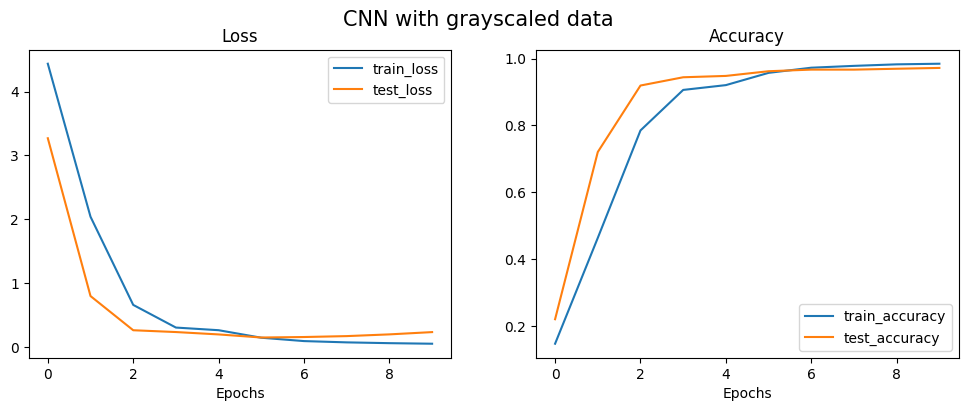

In [35]:
plot_loss_curves(results_custom_gray, title="CNN with grayscaled data")

<Axes: xlabel='labels', ylabel='count'>

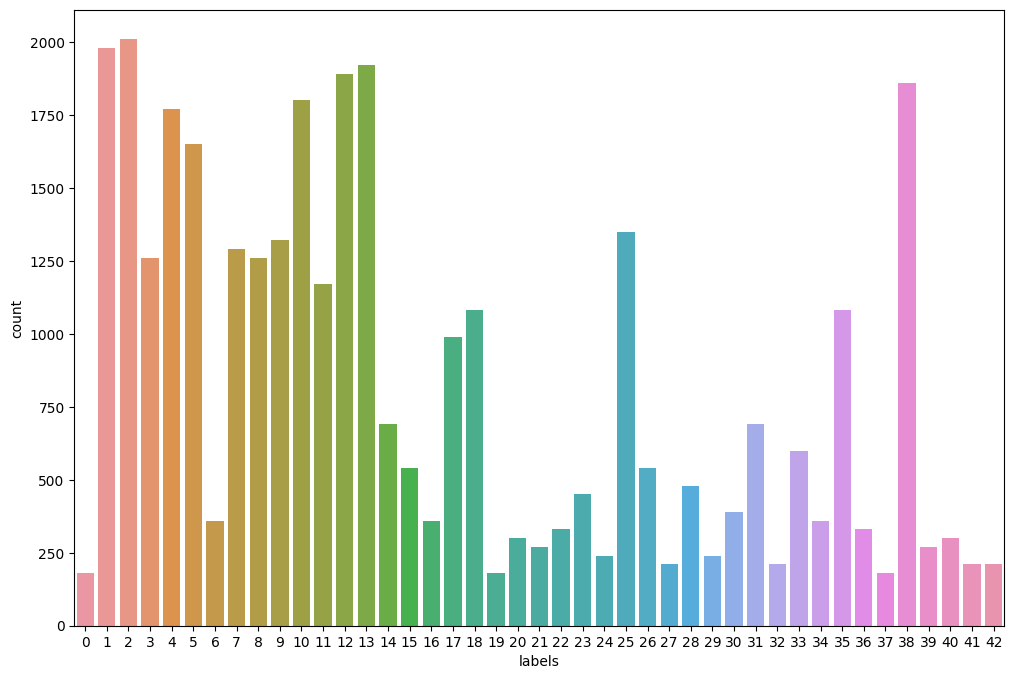

In [37]:
df = pd.DataFrame({'labels':train_data['labels']})
import seaborn as sns
plt.figure(figsize = (12, 8))
sns.countplot(x = 'labels', data= df)